## Lattice and Tensile Test examples

In [7]:
from nematic_order import nematic_order
import matplotlib.pyplot as plt
import numpy as np

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0.5, 1.0, 'Lattice melt test')

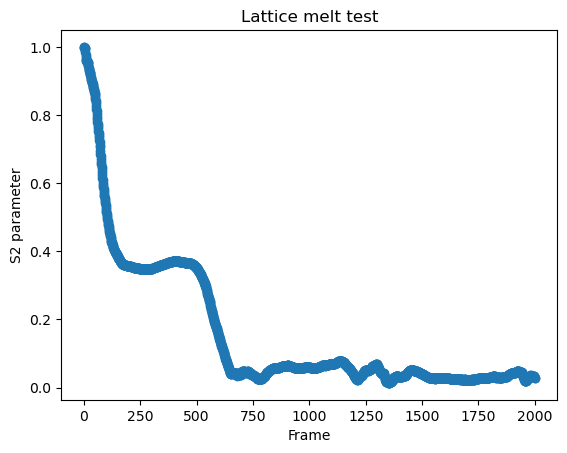

In [2]:
lattice_orders,director = nematic_order("/home/jbieri/CME_lab/projects/SIC/preliminary-work/pps/coarse-graining/pps-melt-cg.gsd")
plt.scatter(range(len(lattice_orders)),lattice_orders)
plt.xlabel("Frame")
plt.ylabel("S2 parameter")
plt.title("Lattice melt test")

Text(0.5, 1.0, 'Tensile test')

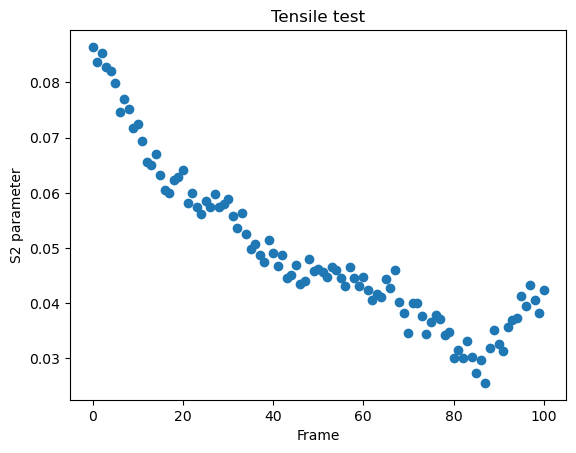

In [15]:
# Tensile test
tensile_orders,director = nematic_order("/home/jbieri/CME_lab/projects/SIC/preliminary-work/pps/coarse-graining/given-pps-cg.gsd")
plt.scatter(range(len(tensile_orders)),tensile_orders)
plt.xlabel("Frame")
plt.ylabel("S2 parameter")
plt.title("Tensile test")

## How to manipulate nematic order vectors

Nematic order is a measure of the average direction of molecules. It is a value between 0 and 1 with a value above 0.3 indicating some form of order within a system. A perfectly ordered system in which the orientations of all particles is alligned will have an order parameter of 1.0 as with the provided lattice melt test graph above.

In [8]:
import freud
import numpy as np
nematic = freud.order.Nematic()
p1 = np.array([0,1,0],[1,0,0])
nematic.compute(p1)
print(nematic.order)


TypeError: Field elements must be 2- or 3-tuples, got '1'

## Bond vectors in opposite directions have the same nematic order

This short example simulation will be used to produce a GSD file with a resulting nematic order that should decrease as the simulation progresses. A graph showing the direction of the director vector of the first frame (as vizualised) will be produced. The nematic order of the initial frame is not 1 as the system is not fully coarse grained. Utilizing GRiTS to coarsegrain beyond removing hydrogens will cause the first frame to have an order of approximately 1.

In [110]:
from flowermd.library import PPS, OPLS_AA_PPS, BeadSpring
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.base import Molecule, Lattice, Simulation
from cmeutils.visualize import FresnelGSD
import gsd
import gsd.hoomd

molecule = PPS(num_mols=2, lengths=10) # Designating number of molecules and their length

box = Lattice(molecules=molecule, x = 2, y = 2, n = 1) # Box size and type
box.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True,remove_charges=True, remove_hydrogens=True)

No charged group detected, skipping electrostatics.


In [111]:
box.to_gsd('unrotated-system.gsd')

In [112]:
old_snap = box.hoomd_snapshot
old_pos = old_snap.particles.position[:70]
R = np.array([[-1,0,0],[0,1,0],[0,0,-1]])

In [113]:
new_pos = np.dot(old_pos, R.T)
print(new_pos[0], old_pos[0])

[ 1.14805984 -1.61828244  8.40081882] [-1.1480598 -1.6182824 -8.400819 ]


In [114]:
old_snap.particles.position[:70] = new_pos

In [115]:
with gsd.hoomd.open("second-after-rotation-snapshot.gsd", "w") as traj:
    traj.append(old_snap)


In [116]:
box.hoomd_snapshot
box.hoomd_snapshot.particles.position[:70] = np.dot(box.hoomd_snapshot.particles.position[:70], R.T)
hoomd_forces = box.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()

In [117]:
sim = Simulation(initial_state='second-after-rotation-snapshot.gsd', forcefield=box.hoomd_forcefield,reference_values=box.reference_values,gsd_write_freq=100, log_write_freq=100, device=cpu, gsd_file_name='small-pps-melt.gsd')

Initializing simulation state from a GSD file.


In [118]:
sim.save_restart_gsd('rotated-system.gsd')

In [107]:
sim.run_NVT(n_steps=1e4, kT=3.0, tau_kt=1.0)
sim.flush_writers()

Step 100 of 10000; TPS: 446.62; ETA: 0.4 minutes
Step 200 of 10000; TPS: 869.21; ETA: 0.2 minutes
Step 300 of 10000; TPS: 1273.04; ETA: 0.1 minutes
Step 400 of 10000; TPS: 1660.58; ETA: 0.1 minutes
Step 500 of 10000; TPS: 2031.36; ETA: 0.1 minutes
Step 600 of 10000; TPS: 2385.59; ETA: 0.1 minutes
Step 700 of 10000; TPS: 2726.29; ETA: 0.1 minutes
Step 800 of 10000; TPS: 3057.74; ETA: 0.1 minutes
Step 900 of 10000; TPS: 3368.87; ETA: 0.0 minutes
Step 1000 of 10000; TPS: 3664.31; ETA: 0.0 minutes
Step 1100 of 10000; TPS: 3959.41; ETA: 0.0 minutes
Step 1200 of 10000; TPS: 4243.4; ETA: 0.0 minutes
Step 1300 of 10000; TPS: 4517.54; ETA: 0.0 minutes
Step 1400 of 10000; TPS: 4782.76; ETA: 0.0 minutes
Step 1500 of 10000; TPS: 5036.19; ETA: 0.0 minutes
Step 1600 of 10000; TPS: 5280.25; ETA: 0.0 minutes
Step 1700 of 10000; TPS: 5520.11; ETA: 0.0 minutes
Step 1800 of 10000; TPS: 5750.69; ETA: 0.0 minutes
Step 1900 of 10000; TPS: 5971.99; ETA: 0.0 minutes
Step 2000 of 10000; TPS: 6187.05; ETA: 0.0 

Plotting the nematic order of the small melt example as the melt occurs

Text(0.5, 1.0, 'Nematic order parameter of small melt simulation by frame')

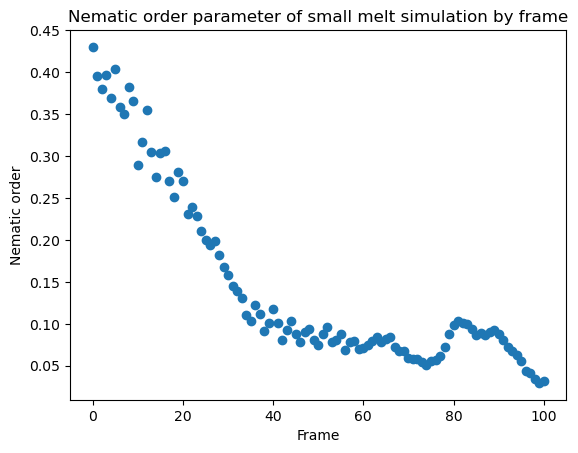

In [108]:
lattice_orders,director = nematic_order('small-pps-melt.gsd')
plt.scatter(range(len(lattice_orders)),lattice_orders)
plt.xlabel('Frame')
plt.ylabel('Nematic order')
plt.title('Nematic order parameter of small melt simulation by frame')

Plotting the nematic director of the small melt example

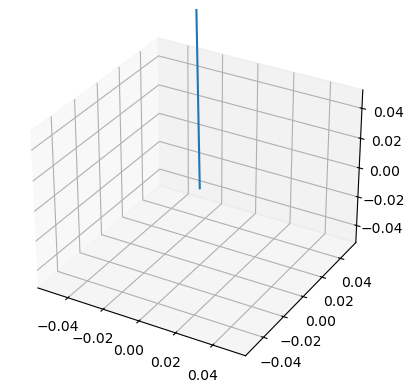

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
director = np.array(director)
ax.quiver(0,0,0,(director[:1,0]),(director[:1,1]),(director[:1,2]))

0.00026720762252807617


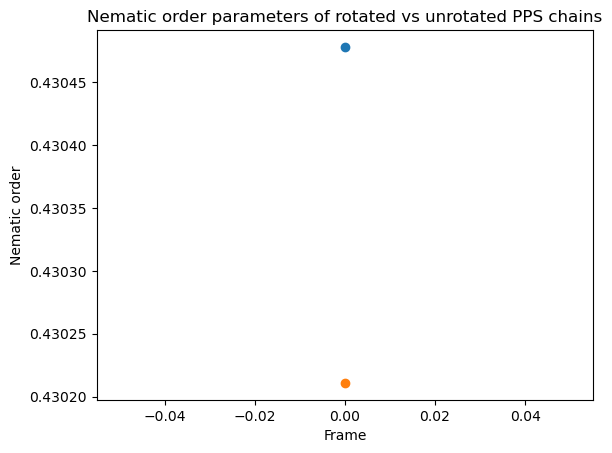

In [123]:
lattice_orders1,director1 = nematic_order('unrotated-system.gsd')
lattice_orders2,director2 = nematic_order('rotated-system.gsd')
plt.scatter(range(len(lattice_orders1)),lattice_orders1)
plt.scatter(range(len(lattice_orders2)),lattice_orders2)
plt.xlabel('Frame')
plt.ylabel('Nematic order')
plt.title('Nematic order parameters of rotated vs unrotated PPS chains')
print(lattice_orders1[0] - lattice_orders2[0])